In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

training_data = np.load('/content/gdrive/My Drive/training_n_data.npy')
training_std = np.load('/content/gdrive/My Drive/training_std.npy')

testing_data = np.load('/content/gdrive/My Drive/testing_n_data.npy')
testing_std = np.load('/content/gdrive/My Drive/testing_std.npy')

# Reshape to 2D Array
training_data = training_data.reshape(training_data.shape[0], 3, -1)
testing_data = testing_data.reshape(testing_data.shape[0], 3, -1)

# Convert to PyTorch tensors
training_data_tensor = torch.tensor(training_data, dtype=torch.float32).to(device)
training_std_tensor = torch.tensor(training_std, dtype=torch.float32).to(device)
testing_data_tensor = torch.tensor(testing_data, dtype=torch.float32).to(device)
testing_std_tensor = torch.tensor(testing_std, dtype=torch.float32).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(training_data_tensor, training_std_tensor)
test_dataset = TensorDataset(testing_data_tensor, testing_std_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

cuda


In [ ]:
np.shape(np.load('/content/gdrive/My Drive/ALD/training_n_data.npy'))

(10000, 120)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 82, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(82 * 37, 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
torch.manual_seed(101)
model = CNN()
model.to(device)

CNN(
  (conv1): Conv1d(3, 82, kernel_size=(4,), stride=(1,))
  (fc1): Linear(in_features=3034, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

TENSORBOARD

In [ ]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

writer.add_graph(model, torch.randn(1, 3, 40))

writer.close()


In [ ]:
%tensorboard --logdir runs

In [ ]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import time
start_time = time.time()

epochs = 400
train_losses = []
test_losses = []

for i in range(epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Run the training batches
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)  # move inputs and outputs to the GPU
        # Apply the model
        y_pred = model(X_train)
        target = y_train.view(-1, 1)  # Adjust the target tensor size
        target = target.expand_as(y_pred)
        loss = criterion(y_pred, target)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Run the testing batches
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)  # move inputs and outputs to the GPU
            # Apply the model
            y_val = model(X_test)

            # Calculate the loss
            target = y_test.view(-1, 1)  # Adjust the target tensor size
            target = target.expand_as(y_val)
            loss = criterion(y_val, target)

            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader)
    test_losses.append(average_test_loss)

    if i % 10 == 0:
        print(f'Epoch: {i}/{epochs} | Train Loss: {average_train_loss:.6f} | Test Loss: {average_test_loss:.6f}')

duration = time.time() - start_time
print(f'\nDuration: {duration} seconds or {duration/60} mins.')  # Print the time elapsed


Epoch: 0/400 | Train Loss: 0.013498 | Test Loss: 0.007477
Epoch: 10/400 | Train Loss: 0.003092 | Test Loss: 0.002615
Epoch: 20/400 | Train Loss: 0.002583 | Test Loss: 0.002646
Epoch: 30/400 | Train Loss: 0.002219 | Test Loss: 0.001737
Epoch: 40/400 | Train Loss: 0.002134 | Test Loss: 0.001830
Epoch: 50/400 | Train Loss: 0.001880 | Test Loss: 0.001618
Epoch: 60/400 | Train Loss: 0.001784 | Test Loss: 0.001667
Epoch: 70/400 | Train Loss: 0.001679 | Test Loss: 0.001491
Epoch: 80/400 | Train Loss: 0.001463 | Test Loss: 0.001239
Epoch: 90/400 | Train Loss: 0.001325 | Test Loss: 0.001148
Epoch: 100/400 | Train Loss: 0.001182 | Test Loss: 0.001441
Epoch: 110/400 | Train Loss: 0.001112 | Test Loss: 0.000822
Epoch: 120/400 | Train Loss: 0.001064 | Test Loss: 0.001159
Epoch: 130/400 | Train Loss: 0.001047 | Test Loss: 0.000818
Epoch: 140/400 | Train Loss: 0.000938 | Test Loss: 0.000654
Epoch: 150/400 | Train Loss: 0.000982 | Test Loss: 0.000775
Epoch: 160/400 | Train Loss: 0.001033 | Test Loss: 

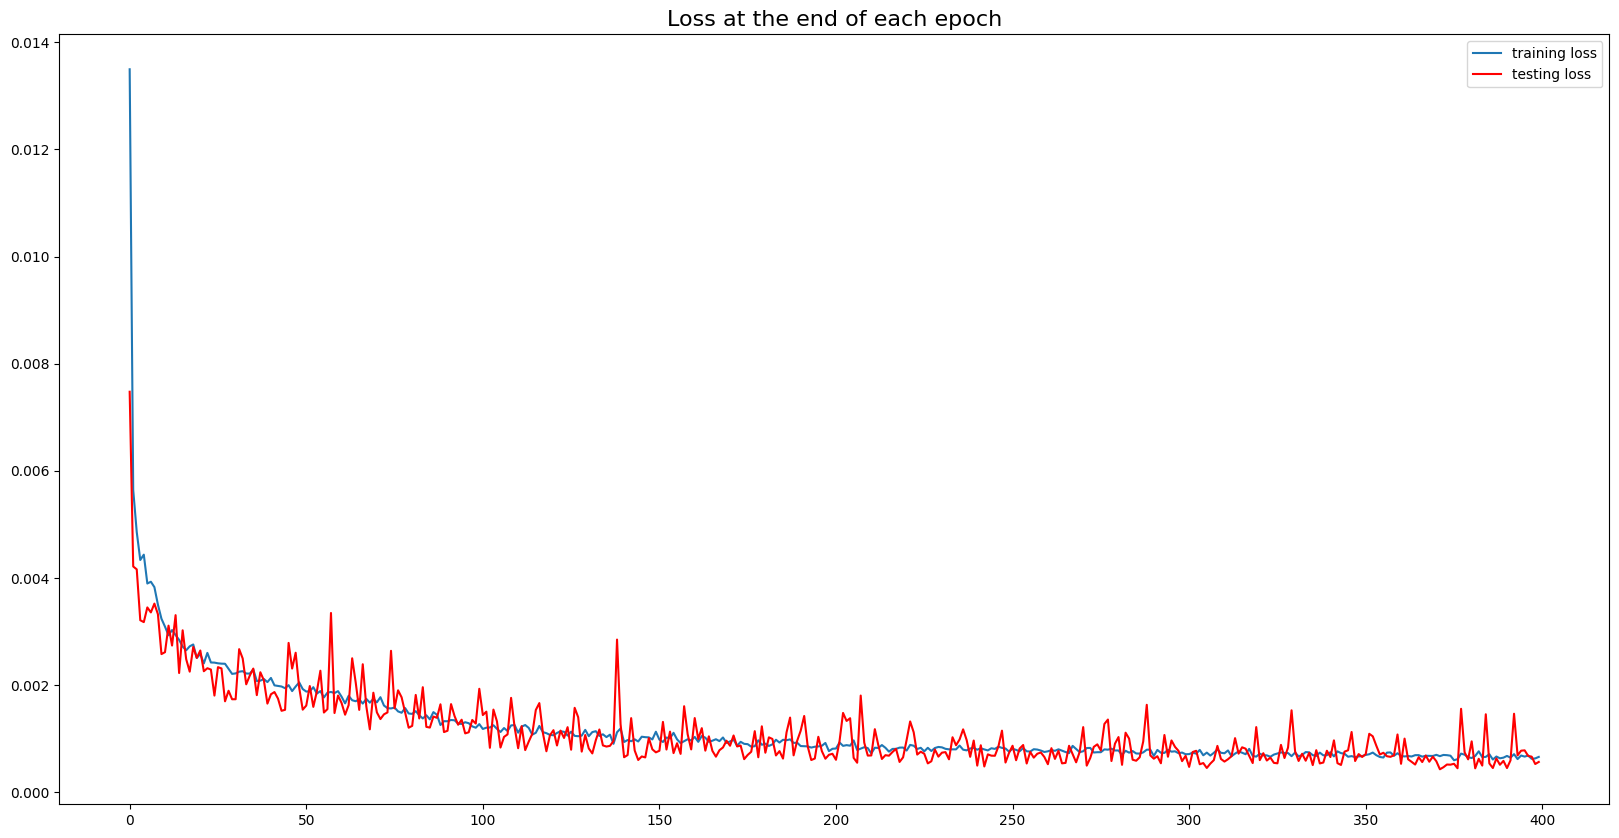

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, 'r', label='testing loss')
plt.title('Loss at the end of each epoch' , fontsize=16)
plt.legend();

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

with torch.no_grad():
    y_pred = model(testing_data_tensor)

    # Convert tensors to CPU
    y_pred_cpu = y_pred.cpu()
    testing_std_tensor_cpu = testing_std_tensor.cpu()

    print("\nMean of y_test: {:.4f}".format(testing_std_tensor_cpu.mean()))
    print("Mean of y_pred: {:.4f}".format(y_pred_cpu.mean()))

    print("\nMedian of y_test: {:.4f}".format(testing_std_tensor_cpu.median()))
    print("Median of y_pred: {:.4f}".format(y_pred_cpu.median()))

    r_squared = r2_score(testing_std_tensor_cpu, y_pred_cpu)
    print("\nR-squared: {}".format(r_squared))
    mse = mean_squared_error(testing_std_tensor_cpu, y_pred_cpu)
    print("\nMSE: {}".format(mse))

    mae = mean_absolute_error(testing_std_tensor_cpu, y_pred_cpu)
    print("\nMAE: {}".format(mae))

    mean_pred = torch.full_like(y_pred_cpu, testing_std_tensor_cpu.mean())
    mean_pred = mean_pred.squeeze()  # Remove unnecessary dimension from mean_pred
    testing_std_tensor_squeeze = testing_std_tensor_cpu.squeeze()  # Remove unnecessary dimension
    mean_mae = F.l1_loss(testing_std_tensor_squeeze, mean_pred)
    print("Baseline MAE: {:.4f}".format(mean_mae))






Mean of y_test: 0.0217
Mean of y_pred: 0.0220

Median of y_test: 0.0056
Median of y_pred: 0.0060

R-squared: 0.999281823768706

MSE: 8.264124176093901e-07

MAE: 0.0005660712486132979
Baseline MAE: 0.0241


In [ ]:
print(y_pred.shape), print(y_test.shape)

torch.Size([1000, 1])
torch.Size([50])


(None, None)

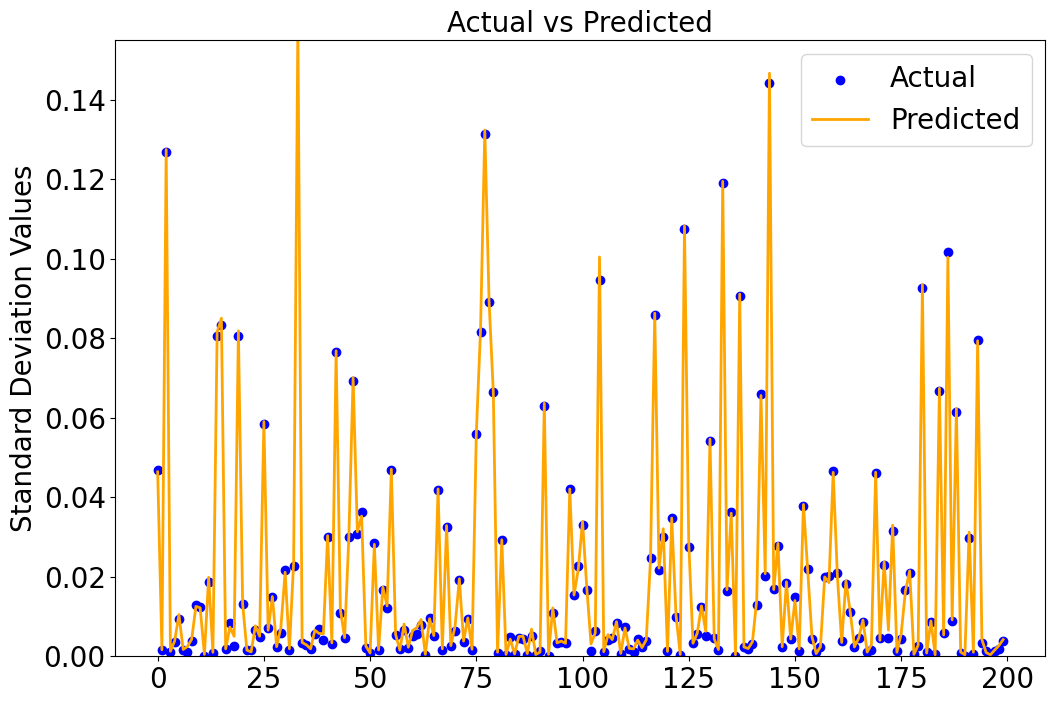

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot the actual values in blue
ax.scatter(range(len(testing_std_tensor[:200].cpu())), testing_std_tensor[:200].cpu(), marker='o', color='blue', label='Actual')



# Plot the predicted values in orange
ax.plot(y_pred[:200].cpu(), color='orange', label='Predicted', linewidth=2)

# Set the title and legend
ax.set_title('Actual vs Predicted', fontsize=20)
ax.set_ylabel('Standard Deviation Values',  fontsize=20)
ax.legend(fontsize=20)
ax.set_ylim(0, 0.155)

# Display the plot
plt.show()